In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'epileptic-seizure-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F63117%2F122455%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T141519Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4d309d45958ba87c2c52ac8fa779ae6086377d10a0f41b967e36ce41a8f2c19f9981a0c57d80908f7be12b1455d35ef5db2966a0b92f79941519a1f4f7b6e2e98da2d5f59261375b1b988678cf53b4f7bdc32d18fa1804e1539b2a02a670aecae1a811a60dd81ebf261b51d084468a06fc5fb73dcefd3c80c47dbf5843d5166a43945eb7d9122ceab8222d8355624f0f07db38ce3456cc73d4672aef9db544f66d575cea0720f2b566f08fee119c409f6eda60b0c116e0c5e930c513f05c497214595addc90391d34e1980fd412ce398f6e8d3224f5708b365acec6d64b7bb3f5e517307e2a9e3153b5887694d8498abf5c0a2e611219006b7d2691137b72f56'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2905621 bytes downloaded
Downloaded and uncompressed: epileptic-seizure-recognition
Data source import complete.


In [ ]:
# imports
import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv


In [ ]:
# read data
raw_data = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')

In [ ]:
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
data = raw_data.values
data = data[1:11501, 1:180]
#data[:, 178] = data[:, 178].astype(int)
data.shape

(11499, 179)

In [ ]:
type(data)

numpy.ndarray

In [ ]:
# Classifying data categories
# Data source: https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition

D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)


(2300, 179)
(2300, 179)
(2300, 179)
(2299, 179)
(2300, 179)


### Experiment 1: Comparing CNN and BiLSTM on Epilepsy versus Healthy Data Categories

In [ ]:
df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

In [ ]:
# Creating training (80), validation (10) and test (10) data from category 1 and 3
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)
label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(3680,) (3680, 178, 1)
(460,) (460, 178, 1)
(460,) (460, 178, 1)


In [ ]:
# Define model evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
# Define CNN network
def network_CNN(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
    batch_normalization = BatchNormalization()(conv1d_1)
    max_pooling1d = layers.MaxPooling1D( 2, padding='same')(batch_normalization)

    conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
    batch_normalization_1 = BatchNormalization()(conv1d_2)
    max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)

    flatten = Flatten()(max_pooling1d_1)

    dense = Dense(32)(flatten)
    dense_1 = Dense(16)(dense)

    main_output = Dense(2)(dense_1)

    model1 = Model(inputs= inputs_cnn, outputs=main_output)
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model1)

In [ ]:
# Define CNN model to be trained on epileptic vs healthy data
model1 = network_CNN(data_train,label_train)
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 32)           224       
                                                                 
 batch_normalization (Batch  (None, 173, 32)           128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 87, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_1 (Bat  (None, 85, 64)            256   

In [ ]:
# Train CNN network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model1.fit(data_train, label_train,epochs=500, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/500
115/115 [==============================] - 4s 19ms/step - loss: 1.0137 - accuracy: 0.6891 - val_loss: 1.3437 - val_accuracy: 0.6696
Epoch 2/500
115/115 [==============================] - 3s 25ms/step - loss: 0.8407 - accuracy: 0.7799 - val_loss: 0.8417 - val_accuracy: 0.7543
Epoch 3/500
115/115 [==============================] - 2s 19ms/step - loss: 0.7141 - accuracy: 0.8234 - val_loss: 0.6175 - val_accuracy: 0.8348
Epoch 4/500
115/115 [==============================] - 2s 18ms/step - loss: 0.6286 - accuracy: 0.8587 - val_loss: 0.4208 - val_accuracy: 0.9043
Epoch 5/500
115/115 [==============================] - 2s 17ms/step - loss: 0.6137 - accuracy: 0.8810 - val_loss: 0.3545 - val_accuracy: 0.8891
Epoch 6/500
115/115 [==============================] - 2s 18ms/step - loss: 0.5446 - accuracy: 0.8908 - val_loss: 0.4493 - val_accuracy: 0.9130
Epoch 7/500
115/115 [==============================] - 2s 17ms/step - loss: 0.8252 - accuracy: 0.8141 - val_loss: 0.7485 - val_accuracy:

Accuracy: 52.39%


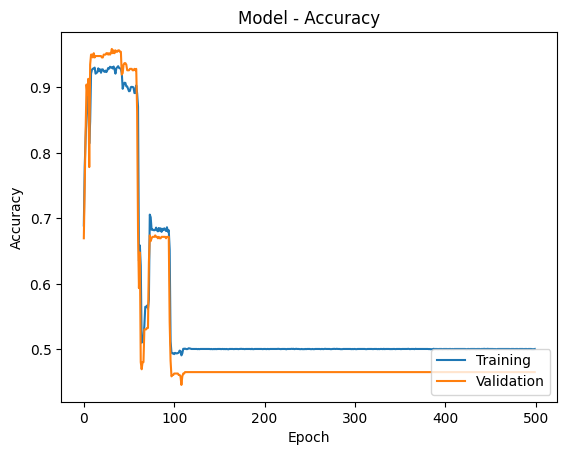

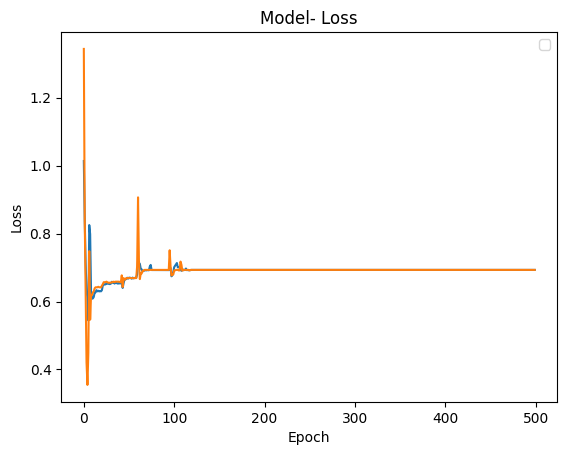

15/15 [==============================] - 0s 6ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history,data_test,label_test,model1)
y_pred=model1.predict(data_test)

Accuracy: 94.13%


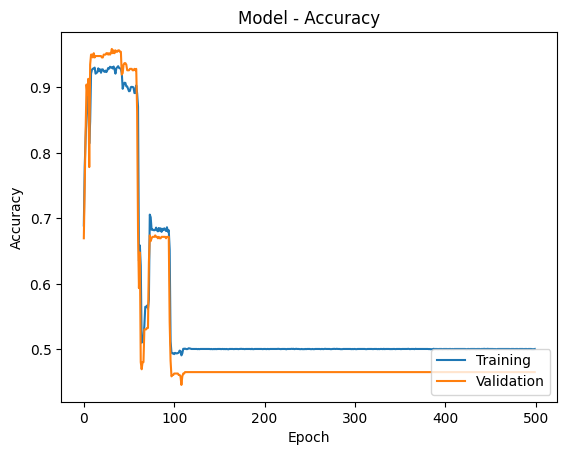

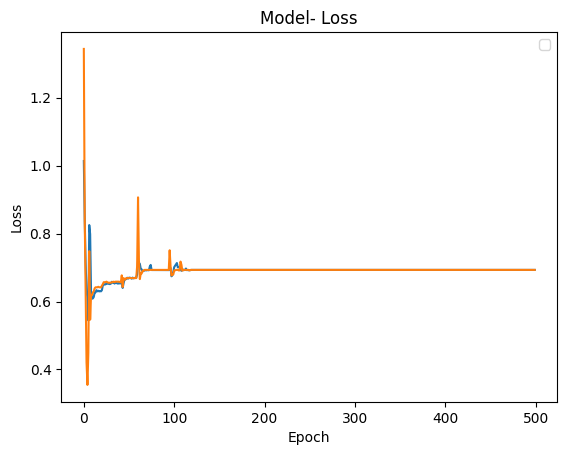

15/15 [==============================] - 0s 6ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model1.load_weights(save_path)
evaluate_model(history,data_test,label_test,model1)

In [ ]:
# Define Bidirectional LSTM model
def network_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
    lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
    dropout = Dropout(0.3)(lstm)
    batch_normalization = BatchNormalization(name='batch_normalization')(dropout)
    dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
    dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
    main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [ ]:
# Define BiLSTM model to be trained on epileptic vs healthy data
model2 = network_LSTM(data_train, label_train)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional (Bidirection  (None, 256)               164864    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [ ]:
# Train BiLSTM on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history2 = model2.fit(data_train, label_train,epochs=100, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
115/115 [==============================] - 51s 399ms/step - loss: 0.2433 - accuracy: 0.9082 - val_loss: 0.1278 - val_accuracy: 0.9674
Epoch 2/100
115/115 [==============================] - 47s 408ms/step - loss: 0.1543 - accuracy: 0.9440 - val_loss: 0.0973 - val_accuracy: 0.9717
Epoch 3/100
115/115 [==============================] - 46s 401ms/step - loss: 0.1418 - accuracy: 0.9514 - val_loss: 0.1044 - val_accuracy: 0.9696
Epoch 4/100
115/115 [==============================] - 47s 406ms/step - loss: 0.1281 - accuracy: 0.9549 - val_loss: 0.0674 - val_accuracy: 0.9783
Epoch 5/100
115/115 [==============================] - 46s 404ms/step - loss: 0.1197 - accuracy: 0.9601 - val_loss: 0.0766 - val_accuracy: 0.9804
Epoch 6/100
115/115 [==============================] - 45s 389ms/step - loss: 0.1027 - accuracy: 0.9663 - val_loss: 0.0705 - val_accuracy: 0.9739
Epoch 7/100
115/115 [==============================] - 47s 408ms/step - loss: 0.1056 - accuracy: 0.9660 - val_loss: 0.0654 -

Accuracy: 99.35%


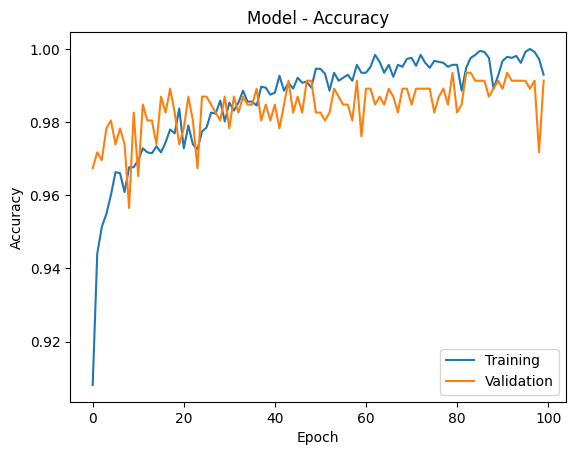

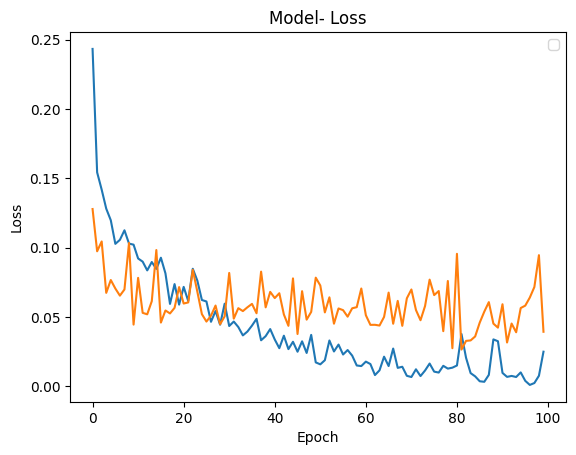

15/15 [==============================] - 3s 111ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history2,data_test,label_test,model2)

Accuracy: 99.35%


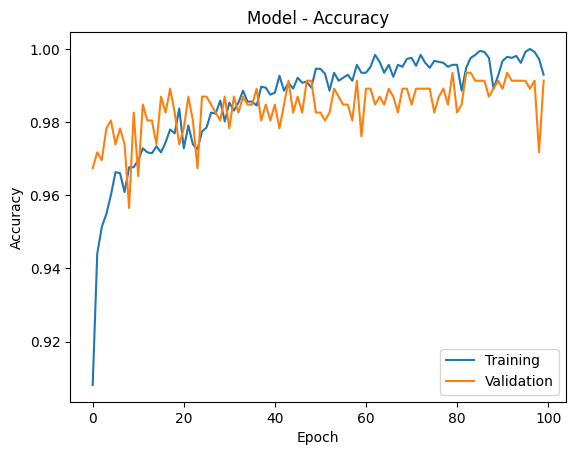

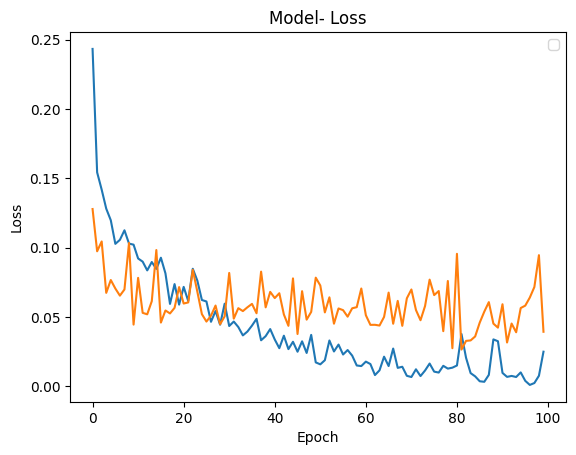

15/15 [==============================] - 2s 142ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model2.load_weights(save_path)
evaluate_model(history2,data_test,label_test,model2)

### Experiment 2: Comparing CNN and BiLSTM on Epilepsy versus All Other Data Categories

In [ ]:
# Define data categories
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2299, 179)
(2300, 179)


In [ ]:
# Concatenate 4 categories into 1 data set
df_2[:, 178] = df_2[:, 178] - 2
df_3[:, 178] = df_3[:, 178] - 3
df_4[:, 178] = df_4[:, 178] - 4
df_5[:, 178] = df_5[:, 178] - 5

D2 = np.concatenate([df_1, df_2, df_3, df_4, df_5])

In [ ]:
# Creating training (80), validation (10) and test (10) data from category 1 and the remaining 4 concatenated
number_of_rows = D2.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train_all = D2[random_indices, -1]
data_train_all = D2[random_indices, :-1]

D2_rest = np.delete(D2, random_indices, 0)

number_of_rows = D2_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val_all = D2_rest[random_indices, -1]
data_val_all = D2_rest[random_indices, :-1]

D2_rest_rest = np.delete(D2_rest, random_indices, 0)
label_test_all = D2_rest_rest[:, -1]
data_test_all = D2_rest_rest[:, :-1]

data_train_all = np.expand_dims(data_train_all, axis=2)
data_val_all = np.expand_dims(data_val_all, axis=2)
data_test_all = np.expand_dims(data_test_all, axis=2)

print(label_train_all.shape, data_train_all.shape)
print(label_val_all.shape, data_val_all.shape)
print(label_test_all.shape, data_test_all.shape)

(9199,) (9199, 178, 1)
(1150,) (1150, 178, 1)
(1150,) (1150, 178, 1)


In [ ]:
# Define CNN model to be trained on epileptic vs all data
model3 = network_CNN(data_train_all,label_train_all)
print(model3.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 173, 32)           224       
                                                                 
 batch_normalization_2 (Bat  (None, 173, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 87, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_3 (Bat  (None, 85, 64)            256 

In [ ]:
# Train CNN model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_3'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history3 = model3.fit(data_train_all, label_train_all,epochs=100, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 7s 18ms/step - loss: 0.9000 - accuracy: 0.7460 - val_loss: 0.7887 - val_accuracy: 0.6878
Epoch 2/100
288/288 [==============================] - 6s 22ms/step - loss: 0.7794 - accuracy: 0.7390 - val_loss: 0.7324 - val_accuracy: 0.7974
Epoch 3/100
288/288 [==============================] - 5s 19ms/step - loss: 0.7169 - accuracy: 0.7958 - val_loss: 0.7264 - val_accuracy: 0.8583
Epoch 4/100
288/288 [==============================] - 6s 21ms/step - loss: 0.7149 - accuracy: 0.7915 - val_loss: 0.6890 - val_accuracy: 0.8130
Epoch 5/100
288/288 [==============================] - 5s 17ms/step - loss: 0.7363 - accuracy: 0.6724 - val_loss: 0.6720 - val_accuracy: 0.6504
Epoch 6/100
288/288 [==============================] - 5s 17ms/step - loss: 0.7164 - accuracy: 0.6621 - val_loss: 0.7043 - val_accuracy: 0.7304
Epoch 7/100
288/288 [==============================] - 6s 19ms/step - loss: 0.6793 - accuracy: 0.6964 - val_loss: 0.6924 - val_accuracy:

Accuracy: 21.04%


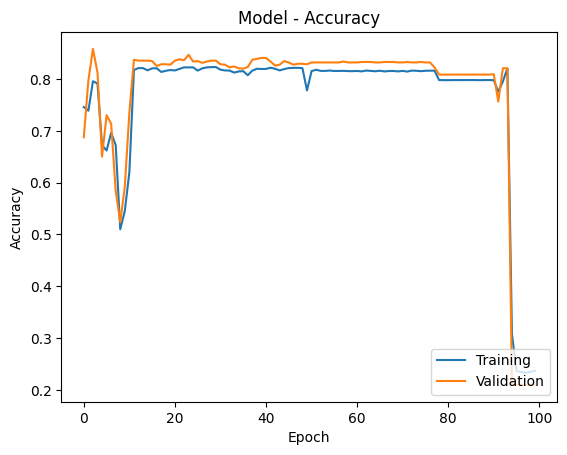

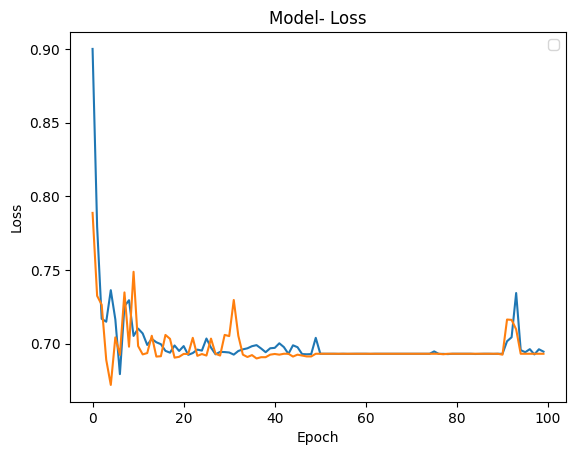

36/36 [==============================] - 0s 6ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history3, data_test_all, label_test_all, model3)

Accuracy: 84.87%


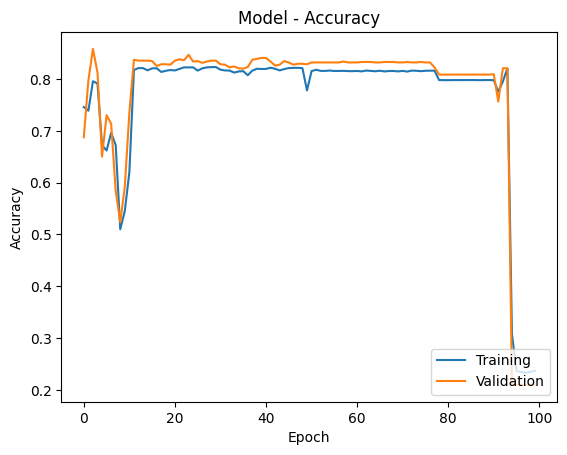

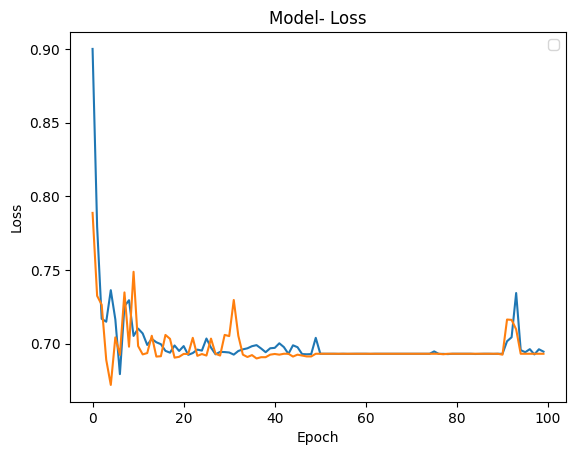

36/36 [==============================] - 0s 6ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model3.load_weights(save_path)
evaluate_model(history3, data_test_all, label_test_all, model3)

In [ ]:
# Define BiLSTM model to be trained on epileptic vs all data
model4 = network_LSTM(data_train_all,label_train_all)
print(model4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               164864    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [ ]:
# Train BiLSTM model on epileptic vs all data
# Save model at highest validation accuracy
import keras

save_path = '/tmp/checkpoint_4'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history4 = model4.fit(data_train_all, label_train_all,epochs=100, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 128s 426ms/step - loss: 0.3036 - accuracy: 0.8877 - val_loss: 0.1579 - val_accuracy: 0.9435
Epoch 2/100
288/288 [==============================] - 128s 446ms/step - loss: 0.1856 - accuracy: 0.9363 - val_loss: 0.1128 - val_accuracy: 0.9565
Epoch 3/100
288/288 [==============================] - 128s 445ms/step - loss: 0.1587 - accuracy: 0.9443 - val_loss: 0.1122 - val_accuracy: 0.9617
Epoch 4/100
288/288 [==============================] - 129s 447ms/step - loss: 0.1467 - accuracy: 0.9496 - val_loss: 0.1299 - val_accuracy: 0.9452
Epoch 5/100
288/288 [==============================] - 128s 444ms/step - loss: 0.1259 - accuracy: 0.9556 - val_loss: 0.0984 - val_accuracy: 0.9635
Epoch 6/100
288/288 [==============================] - 124s 431ms/step - loss: 0.1247 - accuracy: 0.9568 - val_loss: 0.0926 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 124s 432ms/step - loss: 0.1130 - accuracy: 0.9602 - val_loss: 0

Accuracy: 98.70%


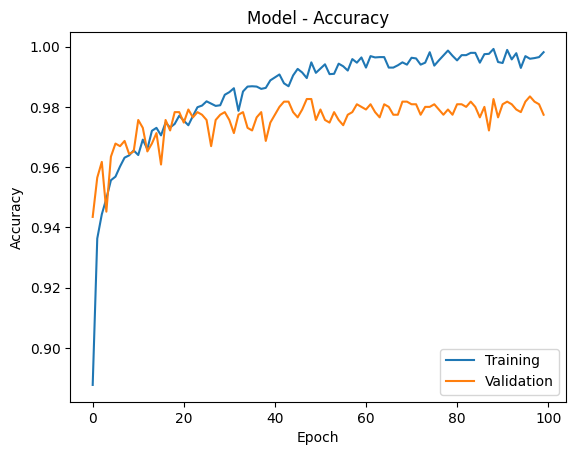

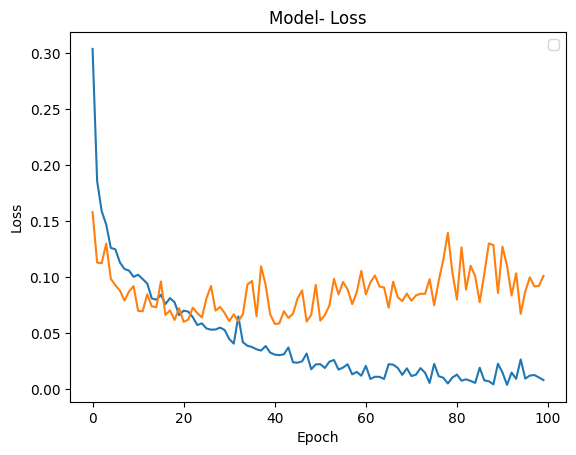

36/36 [==============================] - 7s 117ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model4)

Accuracy: 99.13%


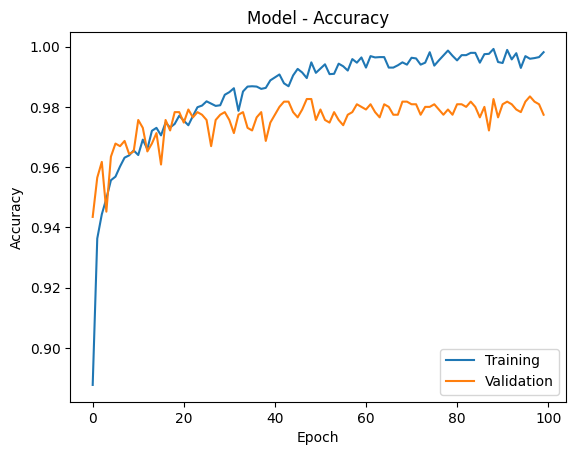

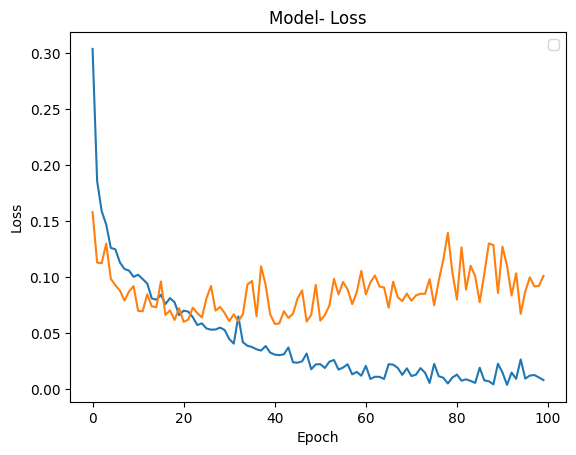

36/36 [==============================] - 6s 159ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model4.load_weights(save_path)
evaluate_model(history4, data_test_all, label_test_all, model4)